In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append('../src/')
from Biologging_Toolkit.applications.Rain import Rain
from Biologging_Toolkit.applications.Wind import Wind
import Biologging_Toolkit.utils.rain_empirical_utils as R_Utils

c:\Users\barsro\Documents\SES_tags\notebooks\../src\Biologging_Toolkit


In [2]:
import sklearn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from tqdm import tqdm
plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "text.usetex": True  
    })

In [3]:
depids = ['ml17_280a','ml18_296a','ml18_294b','ml19_292a','ml19_292b','ml19_293a','ml19_294a','ml20_293a','ml20_296b','ml20_313a','ml21_295a','ml21_305b']
depids_wo293 = ['ml17_280a','ml18_296a','ml18_294b','ml19_292a','ml19_292b','ml19_293a','ml19_294a','ml20_296b','ml20_313a','ml21_295a','ml21_305b'] #'ml20_293a',

path = 'E:/individus_filtered'
freqs = [500, 1000, 2000, 5000, 8000, 10000, 12000, 15000, 16000]
features_csv = ['downwards_mean_500', 'downwards_mean_1000', 'downwards_mean_2500',
       'downwards_mean_5000', 'downwards_mean_8000', 'downwards_mean_10000',
       'downwards_mean_12000', 'downwards_mean_15000', 'downwards_mean_16000','upwards_mean_20000','upwards_mean_5000']

In [4]:
deps = ["ml17_280a"]
inst = Rain(depid=deps, path=[path+f"/{depid}" for depid in deps], df_data = 'csv', frequency = 15000)

---
# Detection
---

<Axes: >

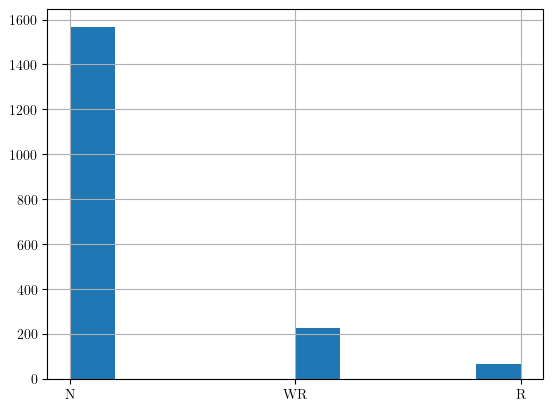

In [5]:
inst.df["weather"].hist()

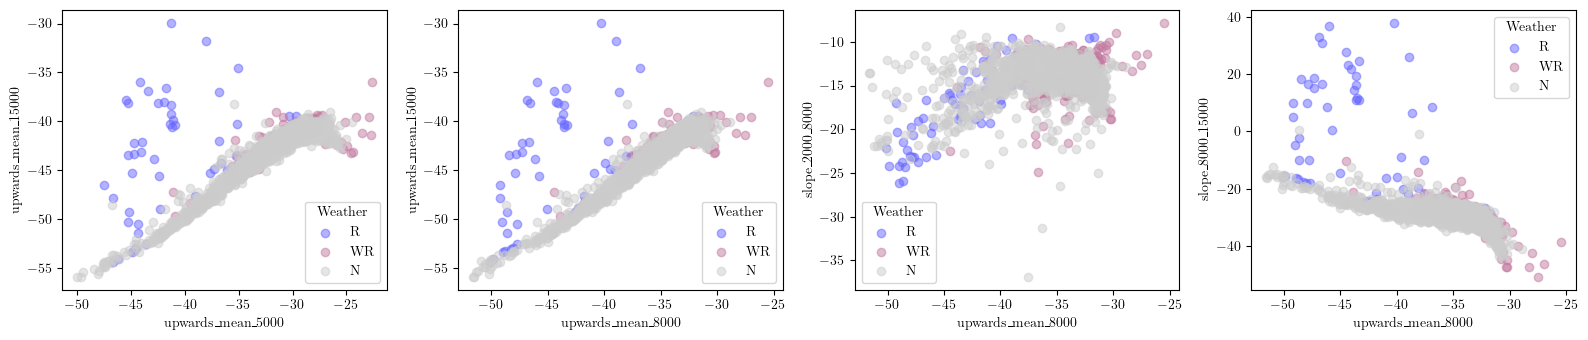

In [6]:
R_Utils.plot_spl_rain(inst.df)

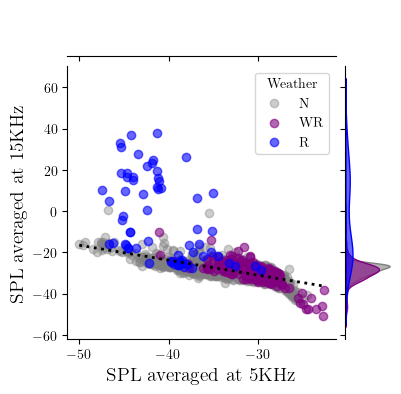

slope_8000_15000 = -0.723282223033631*upwards_mean_5000 - 52.7585757101688
y = -0.7232822230336307 * x + -52.75857571016884


In [7]:
R_Utils.plot_weather_SPL_regression(inst.df,x = "upwards_mean_5000", y = "slope_8000_15000", height=4)

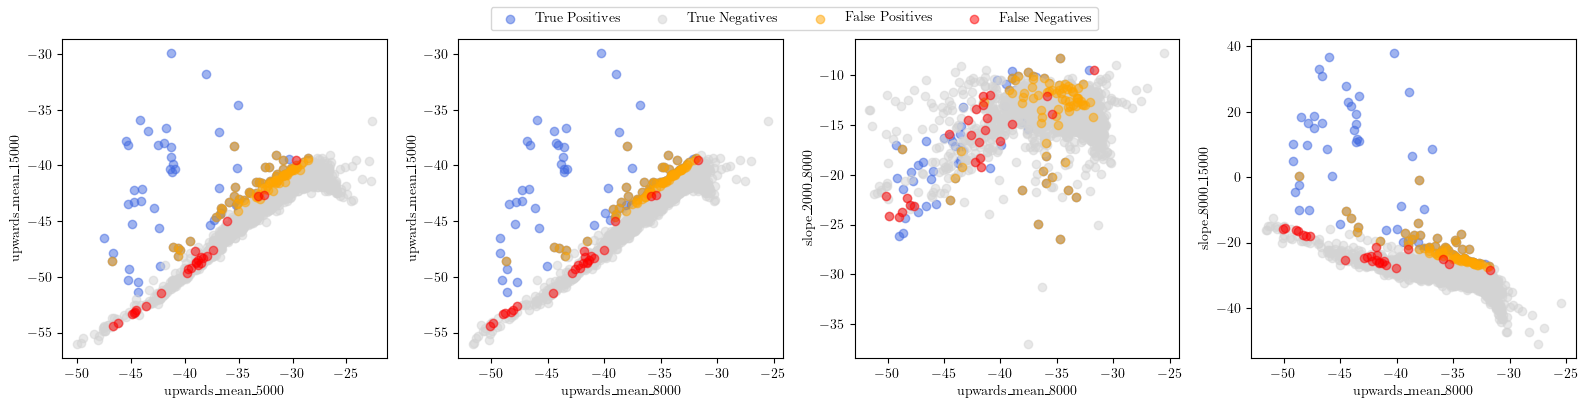

In [8]:
R_Utils.plot_classification_spl(inst.df)

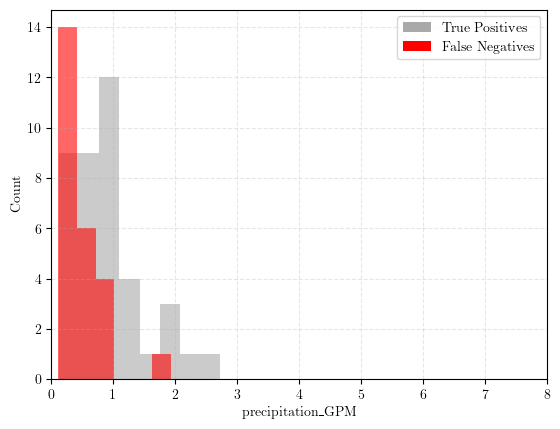

In [9]:
R_Utils.plot_classification_histogram(inst.df)

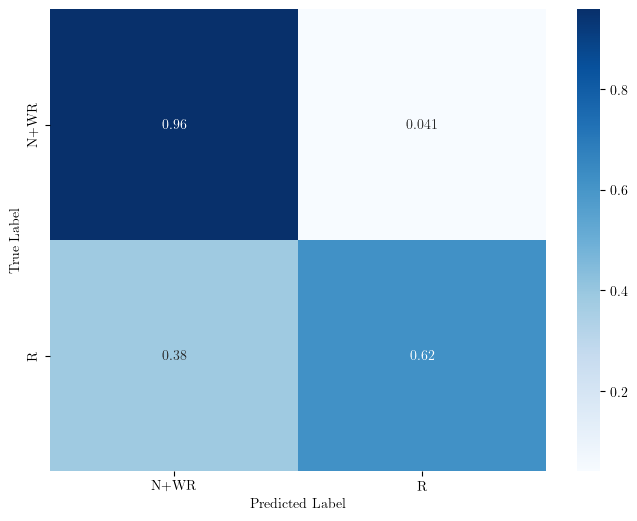

In [10]:
R_Utils.plot_confusion_matrix(inst.df)

### Prec/Recall Curve

100%|██████████| 12/12 [01:52<00:00,  9.37s/it]


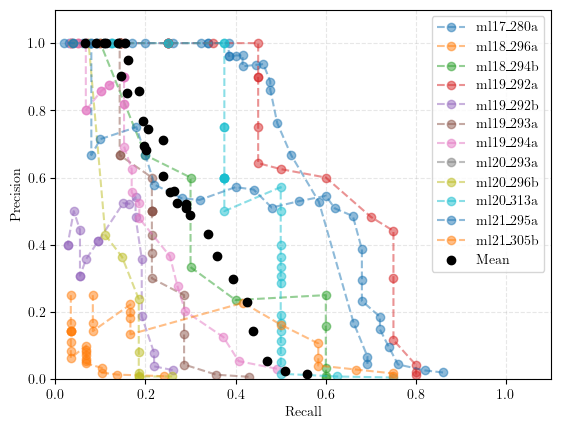

In [11]:
rslts = {}
for depid in tqdm(depids):
    x = []
    y = []

    deps = [depid]
    paths = [path+f"/{depid}" for depid in deps]
    for delta in np.arange(0, 15, 0.5):
        _inst = Rain(depid=deps, path=paths, df_data = 'csv', frequency = 15000, empirical_offset=delta)

        if str(delta) not in rslts:
            rslts[str(delta)] = {"x": [], "y": []}
        precision = sklearn.metrics.precision_score(_inst.df['Rain_Type'], _inst.df['Rain_Type_preds'],pos_label='R', zero_division=0)
        recall = sklearn.metrics.recall_score(_inst.df['Rain_Type'], _inst.df['Rain_Type_preds'],pos_label='R', zero_division=0)

        if recall!= 0 and precision!= 0:
                x.append(recall)
                y.append(precision)
                rslts[str(delta)]["x"].append(recall)
                rslts[str(delta)]["y"].append(precision)
    plt.plot(x, y, linestyle='--', marker='o', label=depid, alpha=0.5)

x_delta_curve = []
y_delta_curve = []
for delta in rslts.keys():
    x_delta_curve.append(np.mean(rslts[delta]["x"]))
    y_delta_curve.append(np.mean(rslts[delta]["y"]))

plt.scatter(x_delta_curve, y_delta_curve, marker="o" , color='black', label='Mean', zorder=5)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1.1)
plt.ylim(0,1.1)
plt.grid(True, linestyle="--", alpha=0.3)

plt.legend()

---
# Estimation
---

In [12]:
# inst.depid_fit(bounds=((0,0),(100,100)))
inst.temporal_fit(bounds=((0,0),(100,100)))
inst.skf_fit(bounds=((0,0),(100,100)),n_splits=8)
print(inst)

Model has been trained with following parameters : 

frequency : upwards_mean_5000
function : <function logRR at 0x000001EBBFB8BD80>
averaging_duration : 4.5
parameters : {'a': 42.5, 'b': 15.2}
ground truth :  IMERG (GPM NASA)
-----------
The model has the following performance :
temporal_mae : 0.47927841985658587
temporal_rmse : 0.49225256449104593
temporal_r2 : -5.727327336607658
temporal_var : 0.04349689386780208
temporal_std : 0.2085590896312172
temporal_cc : -0.09554433797131415
skf_mae : 0.4761122279926947
skf_rmse : 0.660716301220453
skf_r2 : -0.014523995223804431
skf_var : 0.509587369737871
skf_std : 0.6312474273242885
skf_cc : 0.6137715743259072



c:\Users\barsro\.conda\envs\rain\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  warnings.warn(


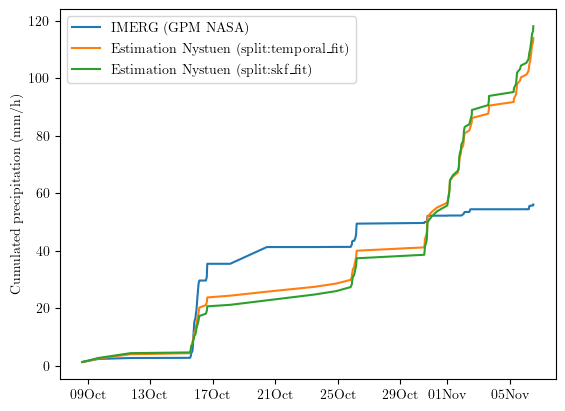

In [13]:
R_Utils.plot_rain_estimation_cumulated(inst)

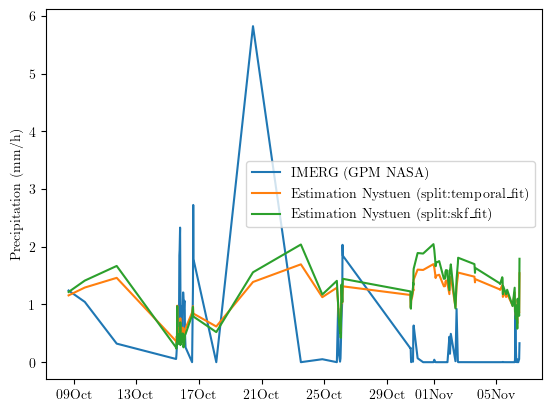

In [14]:
R_Utils.plot_rain_estimation(inst)

## Zoom on ml17_270a data 15-16 October 2017

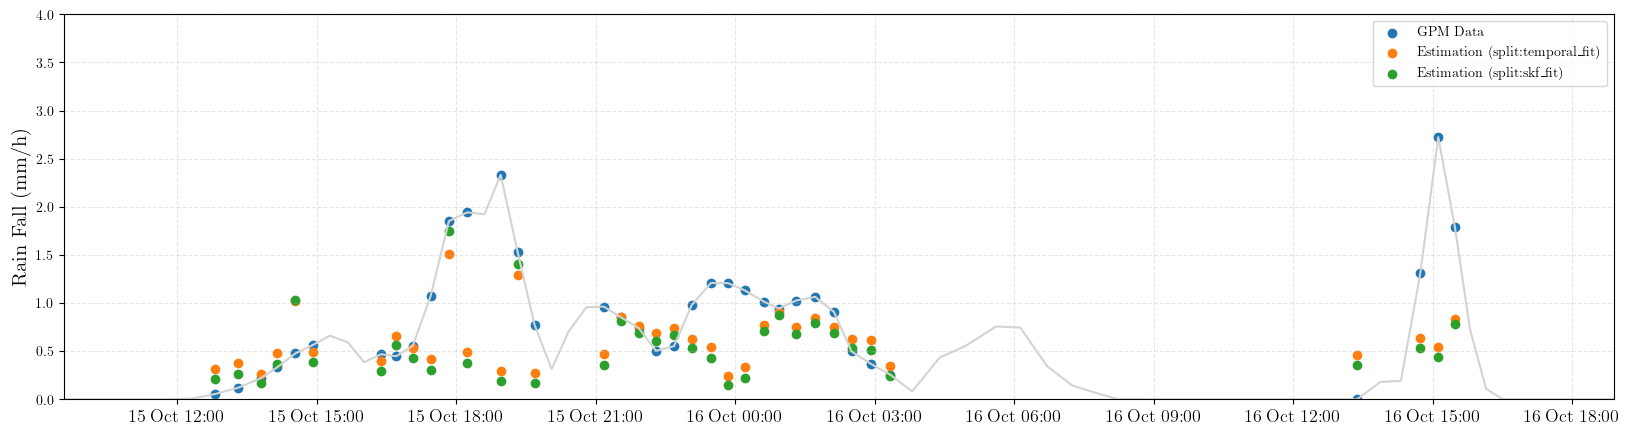

In [15]:
time_dfr = inst.df_r["begin_time"] = pd.to_datetime(inst.df_r["begin_time"], unit='s')
time_df = inst.df["begin_time"] = pd.to_datetime(inst.df["begin_time"], unit='s')

plt.figure(figsize=(20,5))
plt.plot(time_df,inst.df["precipitation_GPM"], c="lightgrey")
plt.scatter(time_dfr,inst.df_r["precipitation_GPM"], label='GPM Data')#, c="royalblue")
for split_rule in inst.popt:
    a,b = inst.popt[split_rule]
    plt.scatter(time_dfr,10**((inst.df_r["upwards_mean_15000"]+a)/b), label=f'Estimation (split:{split_rule})')#, c="lightblue")
plt.ylabel("Rain Fall (mm/h)",fontsize=15)
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %H:%M'))
plt.xlim(pd.to_datetime(6e4 + 1.508e9, unit='s', utc=True),
         pd.to_datetime(1.8e5 + 1.508e9, unit='s', utc=True))
plt.xticks(fontsize=13)
plt.ylim(0,4)
plt.grid(True, linestyle="--", alpha=0.3)
# plt.savefig("../../data-exploration/exports/article/empEst_true_time.pdf")

plt.show()


In [16]:
rslts = {}
for depid in depids:
    rslts[depid]={}
    for freq in freqs :
        rslts[depid][freq] = {}

        deps =[depid]
        paths = [path+f"/{depid}" for depid in deps]

        inst = Rain(depid=deps, path=paths, df_data = 'csv', frequency = freq)
        inst.temporal_fit(bounds=((0,0),(100,100)))
        inst.skf_fit(bounds=((0,0),(100,100)),n_splits=8)
        rslts[depid][freq] = inst.rain_model_stats

c:\Users\barsro\.conda\envs\rain\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  warnings.warn(
c:\Users\barsro\.conda\envs\rain\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  warnings.warn(
c:\Users\barsro\.conda\envs\rain\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  warnings.warn(
c:\Users\barsro\.conda\envs\rain\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  warnings.warn(
c:\Users\barsro\.conda\envs\rain\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  warni

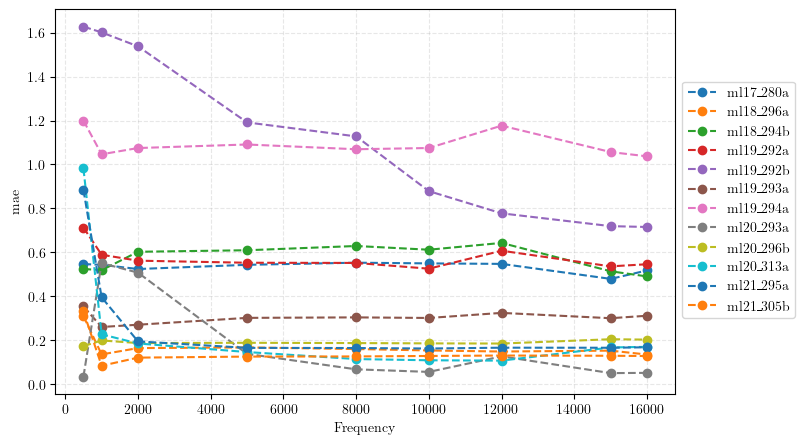

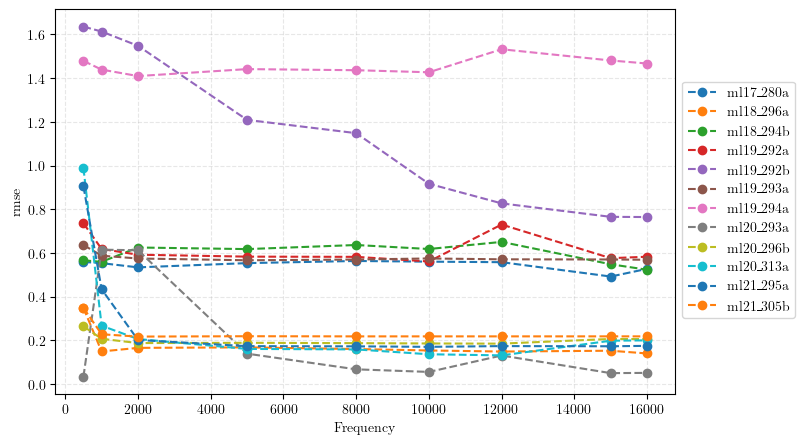

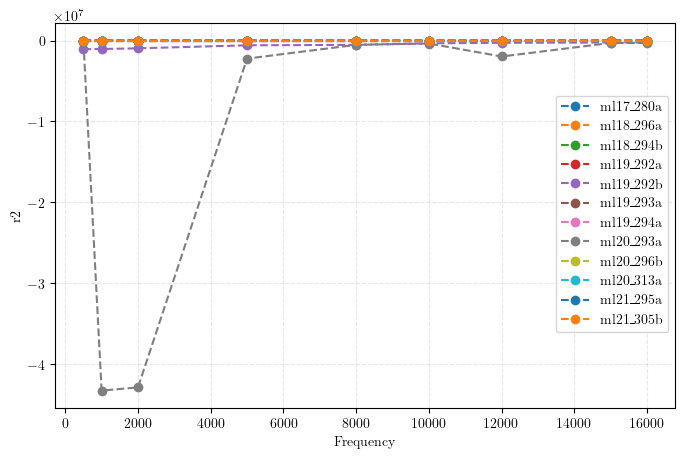

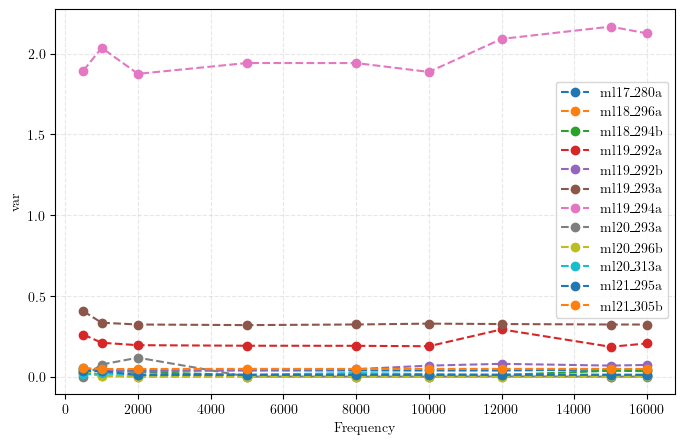

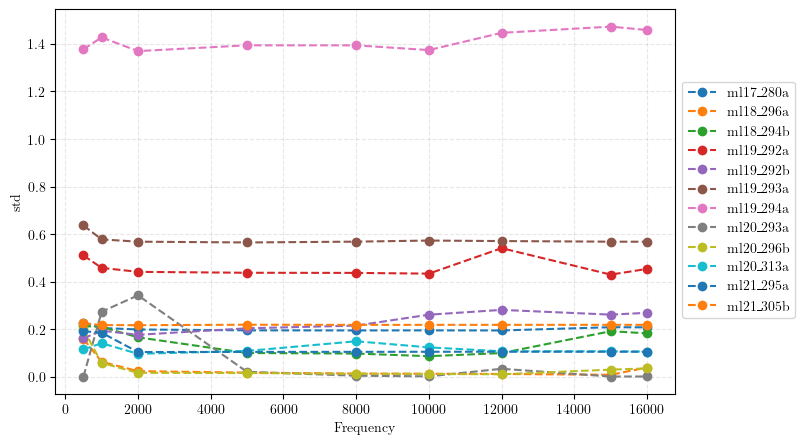

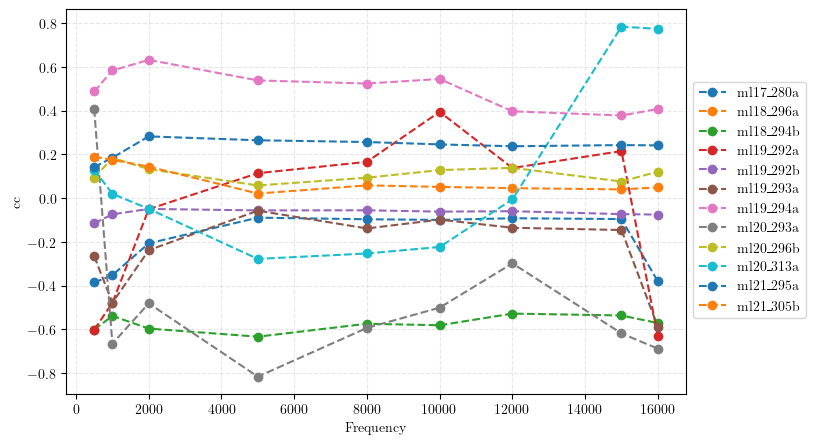

In [17]:
for metric in ["mae", "rmse","r2","var","std","cc"]:
    plt.figure(figsize=(8, 5))

    for depid in rslts :
        temporal_ccs = [rslts[depid][f][f"temporal_{metric}"] for f in freqs]
        plt.plot(freqs, temporal_ccs, marker='o', linestyle='dashed', label=depid)#, color='royalblue')
    plt.xlabel('Frequency')
    plt.ylabel(metric)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(bbox_to_anchor=(1, 0.83))
    plt.show()

---
# Miscellaneous
---

In [118]:
rows = []
for depid, models in rslts.items():
    for model, metrics in models.items():
        rows.append({
            "DepID": depid.replace("_", "\\_"),
            "Frequency": int(re.search(r'\d+$', model).group()),
            "R2": metrics.get("r2"),
        })

df_long = pd.DataFrame(rows)
table_r2 = df_long.pivot(index="Frequency", columns="DepID", values="R2").round(3)

latex_r2 = table_r2.to_latex(
    float_format="%.3f",
    caption="$R^2$ scores per depid for different frequencies",
    label="tab:r2_by_deployment_fitted",
    escape=False
)

print("=== R2 TABLE ===")
print(latex_r2)

=== R2 TABLE ===
\begin{table}
\caption{$R^2$ scores per depid for different frequencies}
\label{tab:r2_by_deployment_fitted}
\begin{tabular}{lrrrrrrrrrrr}
\toprule
DepID & ml17\_280a & ml18\_294b & ml18\_296a & ml19\_292a & ml19\_292b & ml19\_293a & ml19\_294a & ml20\_296b & ml20\_313a & ml21\_295a & ml21\_305b \\
Frequency &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
500 & -1.495 & -3.542 & -32.267 & -0.837 & -0.092 & -12.844 & 0.034 & -12.731 & -30.475 & -6.755 & -102.527 \\
1000 & -0.331 & -0.922 & -12.561 & -0.217 & -0.081 & -3.788 & 0.027 & -5.020 & -7.368 & -3.314 & -40.313 \\
2000 & -0.144 & 0.013 & -1.580 & -0.132 & -0.168 & -1.243 & -0.138 & -0.875 & -1.188 & -1.896 & -5.887 \\
5000 & -0.223 & -0.045 & -0.149 & -0.098 & -0.188 & 0.011 & -0.110 & -0.114 & 0.053 & -0.264 & -0.842 \\
8000 & -0.244 & -0.116 & -0.077 & -0.118 & -0.201 & 0.022 & -0.090 & -0.023 & 0.077 & -0.097 & -0.306 \\
10000 & -0.267 & -0.141 & -0.180 & -0.136 & -0.195 & 0.053 & -0.073 & -0.037 & 0.036 & -0.060

In [94]:
rslts_est = {}

for depid in depids_wo293:
    print(f'>> {depid}')
    rslts_est[depid] = {}

    df = create_df(f"{path}/{depid}/{depid}_dive.csv")
    df = classify_rain(df, offset=1.25, optimised_tresh=False)
    df_r = df[df["Rain_Type_preds"] == "R"].copy()

    for author, a, b in [("Nystuen 2015", -44.35, 30.77),
                         ("Pensieri 2015", -64.40, 25),
                         ("Nystuen 2004", -42.5, 15.4),
                         ("Nystuen 1997", -51.9, 10.6)]:

        rain_est = 10 ** ((df_r["upwards_mean_12000"] + a + 100) / b)
        y_true = df_r["precipitation_GPM"]

        mae = mean_absolute_error(y_true, rain_est)
        mse = mean_squared_error(y_true, rain_est)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, rain_est)
        cc = np.corrcoef(y_true, rain_est)[0, 1]

        rslts_est[depid][author] = {
            "r2": r2,
            "cc": cc,
            "mae": mae,
            "mse": mse,
            "rmse": rmse
        }


>> ml17_280a
>> ml18_296a
>> ml18_294b
>> ml19_292a
>> ml19_292b
>> ml19_293a
>> ml19_294a
>> ml20_296b
>> ml20_313a
>> ml21_295a
>> ml21_305b


In [95]:
rows = []
for depid, models in rslts_est.items():
    for model, metrics in models.items():
        rows.append({
            "DepID": depid.replace("_", "\\_"),
            "Model": model,
            "R2": metrics.get("r2"),
            "CC": metrics.get("cc")
        })

df_long = pd.DataFrame(rows)

table_r2 = df_long.pivot(index="Model", columns="DepID", values="R2").round(3)

latex_r2 = table_r2.to_latex(
    float_format="%.3f",
    caption="$R^2$ scores per depid per coefficient from the bibliography",
    label="tab:r2_by_deployment",
    escape=False
)

print("=== R2 TABLE ===")
print(latex_r2)


=== R2 TABLE ===
\begin{table}
\caption{$R^2$ scores per depid per coefficient from the bibliography}
\label{tab:r2_by_deployment}
\begin{tabular}{lrrrrrrrrrrr}
\toprule
DepID & ml17\_280a & ml18\_294b & ml18\_296a & ml19\_292a & ml19\_292b & ml19\_293a & ml19\_294a & ml20\_296b & ml20\_313a & ml21\_295a & ml21\_305b \\
Model &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Nystuen 1997 & -201.971 & -234.495 & -14133.091 & -255.896 & -31.924 & -746.485 & -6.445 & -498.115 & -724.112 & -21953.444 & -2101.166 \\
Nystuen 2004 & -655.117 & -802.426 & -13324.349 & -613.327 & -35.271 & -2010.869 & -36.228 & -1768.752 & -1917.627 & -4607.156 & -7232.614 \\
Nystuen 2015 & -17.435 & -21.988 & -184.189 & -10.637 & -0.004 & -58.278 & -0.634 & -57.807 & -55.353 & -20.477 & -292.437 \\
Pensieri 2015 & -0.234 & -0.247 & -7.953 & -0.069 & -0.040 & -1.680 & -0.006 & -2.004 & -1.107 & -0.940 & -10.895 \\
\bottomrule
\end{tabular}
\end{table}

